In [14]:
import pandas as pd
import xlrd
import dummy_thread
import openpyxl
import re
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import logging
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime
import sqlite3

In [2]:
%matplotlib inline

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
conn = sqlite3.connect('secfinance.sqlite')
curr = conn.cursor()

In [5]:
curr.executescript('''

DROP TABLE IF EXISTS company;
DROP TABLE IF EXISTS valuetype;
DROP TABLE IF EXISTS summary;
DROP TABLE IF EXISTS dollardenomination;

CREATE TABLE company (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    name TEXT UNIQUE
);

CREATE TABLE valuetype (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    name TEXT UNIQUE
);

CREATE TABLE dollardenomination (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    denomination integer);

CREATE TABLE summary (
    company_id INTEGER,
    valuetype_id INTEGER,
    date TEXT,
    dollaramt INTEGER)
''')

In [6]:
def xlparse(filepath,classname,datein):
    wb = openpyxl.load_workbook(filepath)
    sheetnames = wb.get_sheet_names() #getting list of all sheetnames

    #section for dealing with sheet 1 which is consolidated statement of income
    sheet = wb.get_sheet_by_name(sheetnames[1])
    cola = [] #create new list to store all values in column A
    colb = []
    for cellobj in sheet.columns[0]: #iterate through all values where column0*header column is true..
        cola.append(cellobj.value) #append them to list of columna so we can extract info out of it..

    for cellobj in sheet.columns[1]: #iterate through all values in columnB and store in colb
        colb.append(cellobj.value)

    #extracting information on millions vs thousands from columnArowA
    #format 'Consolidated Condensed Statements of Income - USD ($) shares in Millions, $ in Millions'

    sharedeno = re.findall('shares in ([a-zA-Z]+)',cola[0])
    dollardeno = re.findall('\$ in ([a-zA-Z]+)',cola[0]) #note the use of special character '\' to match for $ vs match at end of line..
    if dollardeno[0] == 'Thousands':
        doldeno = 1000
    elif dollardeno[0] == 'Millions':
        doldeno = 1000000
    else:
        logger.error('Unknown denomination for dollar value')
        
    print sharedeno[0],dollardeno[0] #regular expression returns a list


    #netrevenue  -cost ofsales = grossmargin 
    #grossmargin - operating expenses = operating income
    #operating expenses = randd + marketing + restructuring + amoritization
    #operating income -   gains(losses) on equity investments + iterests and other... = income before taxes
    #income before taxes - provision for taxes = net incomde
    #netincome/basic shares = basic earnings per share 
    #netincome/diluted shares = diluted earnings per share of commone stock

    netrevenuelist = ['Net sales','Netsales','netsales','Net revenue','netrevenue'] #we will want to keep expanding this list based on how many different variants from different companies                                                               
    netincomelist = ['Net income','netincome'] #we will want to keep expanding this list based on how many different variants from different companies         

    logger.debug('%s,%s',cola,colb)
    for name,value in zip(cola,colb): #looping through both cola and b at the same time .. maybe not efficient time wise and better to use index ??
        for entry in netrevenuelist:
            if fuzz.ratio(entry,name) > 70:
                #TODO Add a check for blank cells
                logger.info('%s,%s',name,fuzz.ratio(entry,name))
                netrevenue = value
                curr.execute ('''INSERT OR IGNORE INTO company (name)
            VALUES(?)''',(ticker,))
                curr.execute('''SELECT id FROM company WHERE name = ?''', (ticker,))
                company_id = curr.fetchone()[0]
                curr.execute (''' INSERT OR IGNORE INTO valuetype (name)
                    VALUES(?)''',('netrevenue',))
                curr.execute('''SELECT id FROM valuetype WHERE name = ?''', ('netrevenue',))
                valuetype_id = curr.fetchone()[0]
                #denomination table
                curr.execute('''INSERT OR IGNORE INTO dollardenomination(denomination)
                    VALUES(?)''',(doldeno,))
                curr.execute('''SELECT id FROM valuetype WHERE denomination = ?''', (doldeno,))
                dollardenomination_id = curr.fetchone()[0] #fetching first column since that is the id that can be used as refernece in main table
                
                
                curr.execute('''INSERT OR IGNORE INTO summary (company_id,valuetype_id,date,dollaramt)
        VALUES(?,?,?,?)''', (company_id,valuetype_id,datein,netrevenue))
                
                break
        for entry in netincomelist:
            if fuzz.ratio(entry,name) > 70:
                #TODO Add a check for blank cells
                logger.info('%s,%s',name,fuzz.ratio(entry,name))
                netincome = value
#              curr.execute ('''INSERT OR IGNORE INTO company (name)
#            VALUES(?)''',(ticker,))
#                curr.execute (''' INSERT OR IGNORE INTO valuetype (name)
#                    VALUES(?)''',('netincome',))
                break
    print netrevenue,netincome,datein
  
    conn.commit()
    
    
    return

In [7]:
ticker = raw_input("Enter stock ticker")
classlist = []
datelist = []
# parse all files and create a class for each one of those with data
currentpath = os.getcwd()  #getting current directory of .py script
newpath = currentpath + '\\Tickers\\' + ticker.upper() #planning to create new directory with ticker name in upper case
#if os.path.exists(newpath): #check on if path alrerady exists
for root,dirs,files in os.walk(newpath): #walk returns  root path, directories and then the file names
    for name in files:
        #print name
        filepath = (os.path.join(root, name))
        filename =  name.rstrip('.xls') #removing the .xls extension
        date = re.findall(('\d{4}-\d{2}-\d{2}'), filename)
        datet = datetime.datetime.strptime(date[0], '%Y-%m-%d')
        datelist.append(datet)
        logger.debug('%s %s',filepath,filename)
#filepath = 'C:\Users\Aravind\Dropbox\Learning\Programming\Python\Python Fun\SEC_10k_q\AAPL_10-K_2015-10-28.xlsx'
        #print filename,date[0]
        #print datelist
        xlparse(filepath,filename,date[0])

Enter stock tickeraapl
Thousands Millions


OperationalError: no such column: denomination

In [25]:
datetime.utcnow()

AttributeError: 'module' object has no attribute 'utcnow'

In [27]:
test = '2015-07-22'
test1 = "2016-01-27"


In [28]:
print test

2015-07-22


In [29]:
datetime.date.today()

datetime.date(2016, 6, 9)

In [30]:
testdate = datetime.datetime.strptime(test, '%Y-%m-%d').date()
testdate1 = datetime.datetime.strptime(test1, '%Y-%m-%d').date()

In [34]:
import matplotlib
x = [matplotlib.dates.date2num(testdate),matplotlib.dates.date2num(testdate1)]
x
y = [49605,75872]


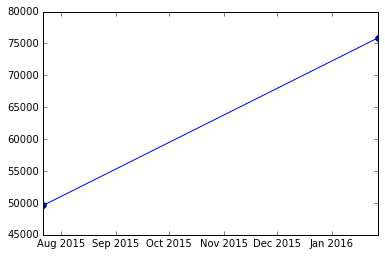

In [45]:
plt.plot_date(x,y,fmt='bo', tz=None, xdate=True,
          ydate=False, ls = 'solid')